## Import library

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import sys
import time
import matplotlib.pyplot as plt

## Set random seed

In [ ]:
np.random.seed(1000)
tf.random.set_seed(1000)

## Generator

In [69]:
# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

## Discriminator

In [70]:
# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Load mnist data

In [71]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

## Train model

In [72]:
def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Print the loss for every p_epoch epochs
        if epoch % p_epoch == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

    
    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc

## 500 epoch

In [54]:
generator_500, d_losses, g_losses, d_acc = train_gan(epochs=500)

1/1 [==============================] - 0s 54ms/step
0 [D loss: 0.6557480692863464, acc.: 53.125%] [G loss: 0.6507036685943604]
1/1 [==============================] - 0s 20ms/step
100 [D loss: 0.605148047208786, acc.: 79.6875%] [G loss: 0.9529576301574707]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
200 [D loss: 0.7096354961395264, acc.: 42.1875%] [G loss: 0.6810082197189331]
1/1 [==============================] - 0s 22ms/step
300 [D loss: 0.7117875814437866, acc.: 35.9375%] [G loss: 0.7169147729873657]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step
400 [D loss: 0.6985068619251251, acc.: 51.5625%] [G loss: 0.711126446723938]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
Total training time: 84.28 seconds


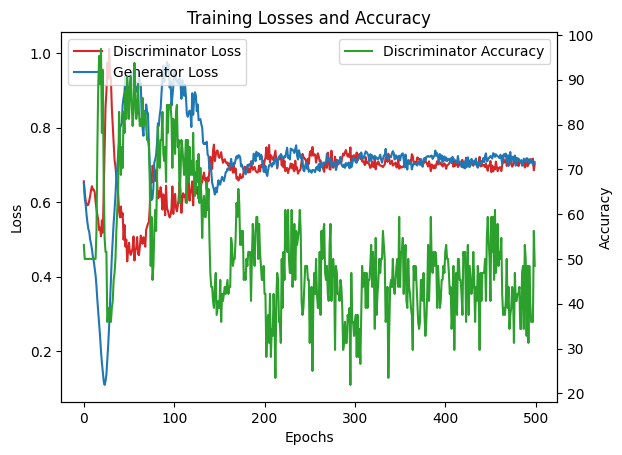

In [55]:
# Plot the losses and accuracy
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(d_losses, label='Discriminator Loss', color='tab:red')
ax1.plot(g_losses, label='Generator Loss', color='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(d_acc, label='Discriminator Accuracy', color='tab:green')
ax2.legend(loc='upper right')

plt.title('Training Losses and Accuracy')
plt.show()

1/1 [==============================] - 0s 63ms/step


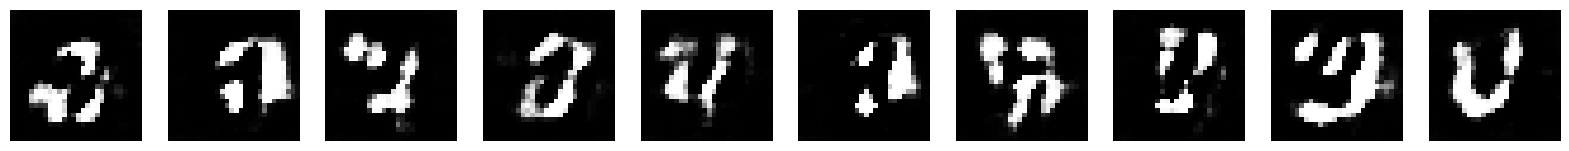

In [57]:
# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_500.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## 1000 epoch

In [60]:
generator_1000, d_losses, g_losses, d_acc = train_gan(epochs=1000)

1/1 [==============================] - 0s 51ms/step
0 [D loss: 0.716392993927002, acc.: 6.25%] [G loss: 0.6713970899581909]
1/1 [==============================] - 0s 23ms/step
100 [D loss: 0.9348827004432678, acc.: 25.0%] [G loss: 0.5777841210365295]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
200 [D loss: 0.7512162029743195, acc.: 32.8125%] [G loss: 0.6991668343544006]
1/1 [==============================] - 0s 20ms/step
300 [D loss: 0.7381265461444855, acc.: 29.6875%] [G loss: 0.7108285427093506]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
400 [D loss: 0.7158217132091522, acc.: 39.0625%] [G loss: 0.716606855392456]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
500 [D loss: 0.6999326348304749, acc.: 50.0%] [G loss: 0.7222530841827393]
1/1 [==============================] - 0s 20ms/step
600 [D loss: 0.7048472762107849, acc.: 46.875%] [G loss: 0.7031831741333008]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
700 [D loss: 0.698183685541153, acc.: 48.4375%] [G loss: 0.7228792309761047]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
800 [D loss: 0.6936401724815369, acc.: 50.0%] [G loss: 0.7215422987937927]
1/1 [==============================] - 0s 21ms/step
900 [D loss: 0.6888047158718109, acc.: 59.375%] [G loss: 0.7243008017539978]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
Total training time: 164.66 seconds


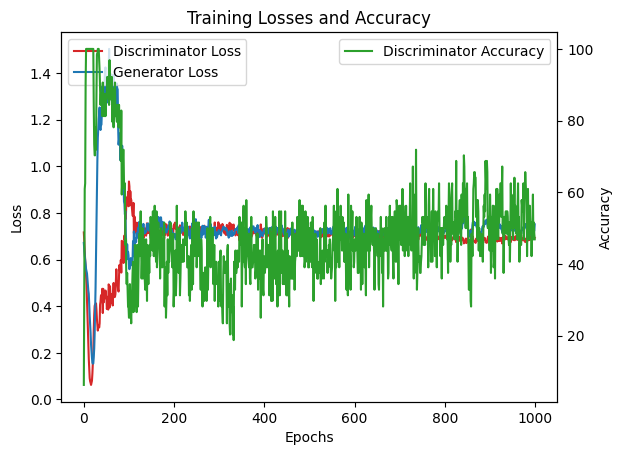

In [61]:
# Plot the losses and accuracy
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(d_losses, label='Discriminator Loss', color='tab:red')
ax1.plot(g_losses, label='Generator Loss', color='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(d_acc, label='Discriminator Accuracy', color='tab:green')
ax2.legend(loc='upper right')

plt.title('Training Losses and Accuracy')
plt.show()

1/1 [==============================] - 0s 50ms/step


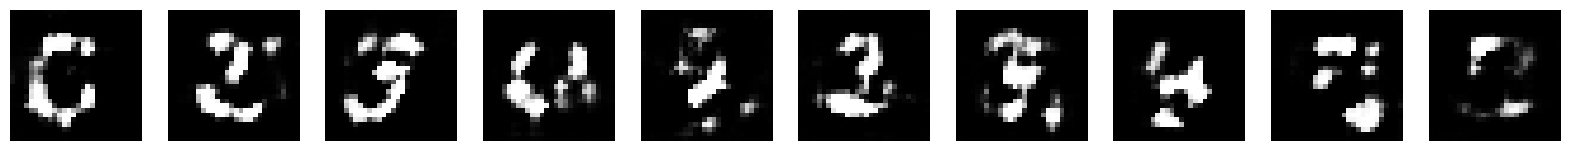

In [62]:
# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_1000.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## 2000 epochs

In [65]:
generator_2000, d_losses, g_losses, d_acc = train_gan(epochs=2000)

1/1 [==============================] - 0s 52ms/step
0 [D loss: 0.6840874254703522, acc.: 37.5%] [G loss: 0.6552673578262329]
1/1 [==============================] - 0s 22ms/step
100 [D loss: 0.7127707600593567, acc.: 53.125%] [G loss: 0.7276592254638672]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
200 [D loss: 0.7259064316749573, acc.: 28.125%] [G loss: 0.698292076587677]
1/1 [==============================] - 0s 21ms/step
300 [D loss: 0.7079243659973145, acc.: 37.5%] [G loss: 0.7039860486984253]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step
400 [D loss: 0.7085703611373901, acc.: 50.0%] [G loss: 0.7369027137756348]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
500 [D loss: 0.7057380080223083, acc.: 43.75%] [G loss: 0.7354227304458618]
1/1 [==============================] - 0s 22ms/step
600 [D loss: 0.709265410900116, acc.: 39.0625%] [G loss: 0.7257336974143982]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
700 [D loss: 0.7042928338050842, acc.: 43.75%] [G loss: 0.7177120447158813]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
800 [D loss: 0.6942430138587952, acc.: 50.0%] [G loss: 0.7202935218811035]
1/1 [==============================] - 0s 21ms/step
900 [D loss: 0.6791907250881195, acc.: 59.375%] [G loss: 0.733022928237915]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step
1000 [D loss: 0.6921384334564209, acc.: 60.9375%] [G loss: 0.7307553887367249]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
1100 [D loss: 0.6886642575263977, acc.: 53.125%] [G loss: 0.7417973279953003]
1/1 [==============================] - 0s 21ms/step
1200 [D loss: 0.6821479797363281, acc.: 60.9375%] [G loss: 0.714817225933075]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
1300 [D loss: 0.6900663375854492, acc.: 51.5625%] [G loss: 0.7084537148475647]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
1400 [D loss: 0.6756250262260437, acc.: 62.5%] [G loss: 0.7170555591583252]
1/1 [==============================] - 0s 20ms/step
1500 [D loss: 0.6868204474449158, acc.: 53.125%] [G loss: 0.7217161655426025]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
1600 [D loss: 0.685730367898941, acc.: 59.375%] [G loss: 0.728018045425415]
1/1 [==============================] - 0s 19ms/step
1700 [D loss: 0.6720764636993408, acc.: 65.625%] [G loss: 0.732757568359375]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
1800 [D loss: 0.6834423243999481, acc.: 62.5%] [G loss: 0.7014503479003906]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
1900 [D loss: 0.6948897242546082, acc.: 50.0%] [G loss: 0.6996381878852844]
1/1 [==============================] - 0s 21ms/step
Total training time: 334.80 seconds


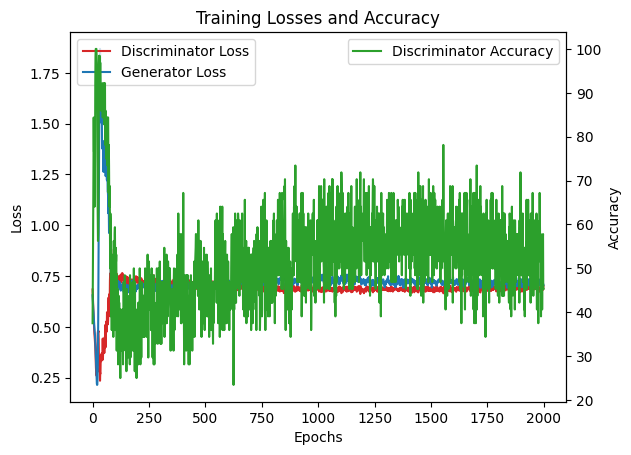

In [66]:
# Plot the losses and accuracy
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(d_losses, label='Discriminator Loss', color='tab:red')
ax1.plot(g_losses, label='Generator Loss', color='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(d_acc, label='Discriminator Accuracy', color='tab:green')
ax2.legend(loc='upper right')

plt.title('Training Losses and Accuracy')
plt.show()

1/1 [==============================] - 0s 17ms/step


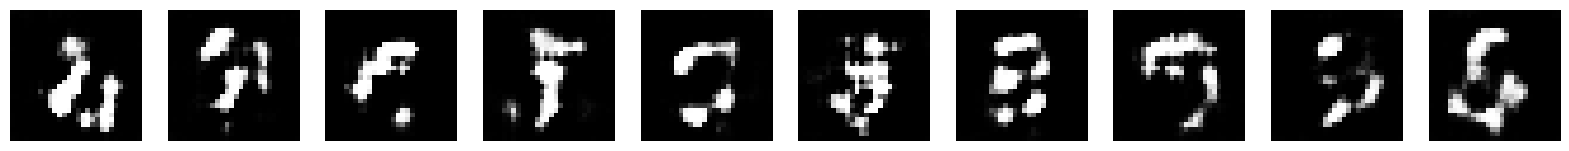

In [67]:
# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_2000.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## 5000 epochs

In [73]:
generator_5000, d_losses, g_losses, d_acc = train_gan(epochs=5000)

1/1 [==============================] - 0s 54ms/step
0 [D loss: 0.6903582513332367, acc.: 29.6875%] [G loss: 0.659030556678772]
1/1 [==============================] - 0s 20ms/step
100 [D loss: 0.6980545222759247, acc.: 56.25%] [G loss: 0.7776347994804382]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
200 [D loss: 0.691962331533432, acc.: 56.25%] [G loss: 0.7244467735290527]
1/1 [==============================] - 0s 24ms/step
300 [D loss: 0.7213085889816284, acc.: 34.375%] [G loss: 0.7075145244598389]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
400 [D loss: 0.6930700838565826, acc.: 54.6875%] [G loss: 0.7031604647636414]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
500 [D loss: 0.6899036765098572, acc.: 60.9375%] [G loss: 0.7080885767936707]
1/1 [==============================] - 0s 20ms/step
600 [D loss: 0.6867699027061462, acc.: 59.375%] [G loss: 0.7909194231033325]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
700 [D loss: 0.6796718537807465, acc.: 70.3125%] [G loss: 0.706298291683197]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
800 [D loss: 0.6939051747322083, acc.: 53.125%] [G loss: 0.7423784136772156]
1/1 [==============================] - 0s 21ms/step
900 [D loss: 0.6872076392173767, acc.: 59.375%] [G loss: 0.7250529527664185]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step
1000 [D loss: 0.6770791411399841, acc.: 65.625%] [G loss: 0.7306606769561768]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
1100 [D loss: 0.6891993284225464, acc.: 53.125%] [G loss: 0.7200143337249756]
1/1 [==============================] - 0s 21ms/step
1200 [D loss: 0.6958707571029663, acc.: 54.6875%] [G loss: 0.7088478803634644]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
1300 [D loss: 0.6702669262886047, acc.: 68.75%] [G loss: 0.7251210808753967]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
1400 [D loss: 0.6926123797893524, acc.: 50.0%] [G loss: 0.7053502798080444]
1/1 [==============================] - 0s 19ms/step
1500 [D loss: 0.6822056174278259, acc.: 59.375%] [G loss: 0.7182742953300476]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
1600 [D loss: 0.6881143450737, acc.: 45.3125%] [G loss: 0.7119210958480835]
1/1 [==============================] - 0s 21ms/step
1700 [D loss: 0.6948447525501251, acc.: 45.3125%] [G loss: 0.7257800102233887]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
1800 [D loss: 0.6945981979370117, acc.: 51.5625%] [G loss: 0.713109016418457]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
1900 [D loss: 0.6963818669319153, acc.: 45.3125%] [G loss: 0.7059447169303894]
1/1 [==============================] - 0s 21ms/step
2000 [D loss: 0.6984899640083313, acc.: 45.3125%] [G loss: 0.6981664896011353]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
2100 [D loss: 0.7052769064903259, acc.: 42.1875%] [G loss: 0.7054733633995056]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
2200 [D loss: 0.6995892226696014, acc.: 43.75%] [G loss: 0.7062238454818726]
1/1 [==============================] - 0s 24ms/step
2300 [D loss: 0.7050610482692719, acc.: 39.0625%] [G loss: 0.7116753458976746]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
2400 [D loss: 0.6920555830001831, acc.: 50.0%] [G loss: 0.6912115216255188]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
2500 [D loss: 0.7000761330127716, acc.: 45.3125%] [G loss: 0.7089509963989258]
1/1 [==============================] - 0s 22ms/step
2600 [D loss: 0.6925302445888519, acc.: 53.125%] [G loss: 0.7230740785598755]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
2700 [D loss: 0.7079221606254578, acc.: 39.0625%] [G loss: 0.7044790983200073]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
2800 [D loss: 0.6969181001186371, acc.: 45.3125%] [G loss: 0.7081664800643921]
1/1 [==============================] - 0s 24ms/step
2900 [D loss: 0.6968667507171631, acc.: 48.4375%] [G loss: 0.6997131109237671]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step
3000 [D loss: 0.6979833245277405, acc.: 46.875%] [G loss: 0.7066589593887329]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
3100 [D loss: 0.7102928459644318, acc.: 37.5%] [G loss: 0.69500732421875]
1/1 [==============================] - 0s 21ms/step
3200 [D loss: 0.6892379820346832, acc.: 56.25%] [G loss: 0.6999149322509766]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
3300 [D loss: 0.6944255530834198, acc.: 46.875%] [G loss: 0.717241644859314]
1/1 [==============================] - 0s 22ms/step
3400 [D loss: 0.7020292282104492, acc.: 51.5625%] [G loss: 0.7107768654823303]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
3500 [D loss: 0.6991919577121735, acc.: 43.75%] [G loss: 0.6909093260765076]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
3600 [D loss: 0.6999096274375916, acc.: 42.1875%] [G loss: 0.7086235880851746]
1/1 [==============================] - 0s 21ms/step
3700 [D loss: 0.6893770098686218, acc.: 53.125%] [G loss: 0.7063883543014526]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step
3800 [D loss: 0.7056487202644348, acc.: 42.1875%] [G loss: 0.6980137228965759]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
3900 [D loss: 0.6978155076503754, acc.: 43.75%] [G loss: 0.7153264284133911]
1/1 [==============================] - 0s 21ms/step
4000 [D loss: 0.6938791871070862, acc.: 50.0%] [G loss: 0.6928665637969971]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
4100 [D loss: 0.6966837346553802, acc.: 42.1875%] [G loss: 0.7039934396743774]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
4200 [D loss: 0.694155365228653, acc.: 46.875%] [G loss: 0.7074239253997803]
1/1 [==============================] - 0s 21ms/step
4300 [D loss: 0.6962326169013977, acc.: 43.75%] [G loss: 0.7110859155654907]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
4400 [D loss: 0.7127805650234222, acc.: 37.5%] [G loss: 0.7382804155349731]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
4500 [D loss: 0.6971817910671234, acc.: 42.1875%] [G loss: 0.7081165313720703]
1/1 [==============================] - 0s 24ms/step
4600 [D loss: 0.6881121098995209, acc.: 54.6875%] [G loss: 0.7059895396232605]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
4700 [D loss: 0.685470312833786, acc.: 60.9375%] [G loss: 0.7160729765892029]
1/1 [==============================] - 0s 22ms/step
4800 [D loss: 0.7055943012237549, acc.: 43.75%] [G loss: 0.7163217067718506]


1/1 [==============================] - 0s 21ms/step
4900 [D loss: 0.6823979616165161, acc.: 60.9375%] [G loss: 0.7063992023468018]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
Total training time: 819.06 seconds


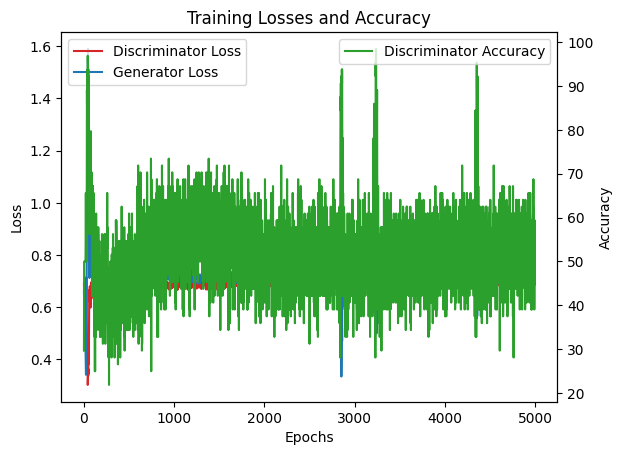

In [74]:
# Plot the losses and accuracy
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(d_losses, label='Discriminator Loss', color='tab:red')
ax1.plot(g_losses, label='Generator Loss', color='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(d_acc, label='Discriminator Accuracy', color='tab:green')
ax2.legend(loc='upper right')

plt.title('Training Losses and Accuracy')
plt.show()

1/1 [==============================] - 0s 51ms/step


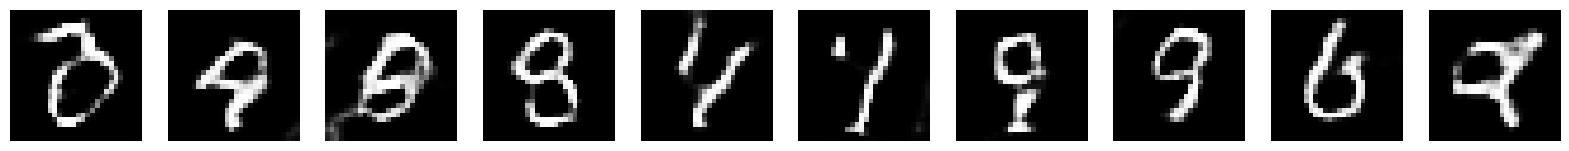

In [76]:
# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_5000.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()